# Industry Project

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Подготовка данных

Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')

Загрузка файлов и их объединение в общий список для удобства обращения.

In [3]:
arc = pd.read_csv("//datasets/final_steel/data_arc.csv", 
                     parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
bulk = pd.read_csv("//datasets/final_steel/data_bulk.csv")
bulk_time = pd.read_csv("//datasets/final_steel/data_bulk_time.csv")
gas = pd.read_csv("//datasets/final_steel/data_gas.csv")
temp = pd.read_csv("//datasets/final_steel/data_temp.csv", parse_dates=['Время замера'])
wire = pd.read_csv("//datasets/final_steel/data_wire.csv")
wire_time = pd.read_csv("//datasets/final_steel/data_wire_time.csv")

all_df = [arc, bulk, bulk_time, gas, temp, wire, wire_time]

Функция для поиска пропусков

In [4]:
def research_pass(df):
    count_pass = df.isnull().sum()
    count_pass_perc = count_pass * 100 / len(df)
    
    table_pass = pd.concat([count_pass, count_pass_perc], axis=1)
    table_pass.columns = ['count_pass', '% pass']
    
    table_pass = table_pass[table_pass['% pass'] != 0].sort_values('% pass', ascending=False)
    
    if len(table_pass) == 0:
        return 'Пропуски не обнаружены'
    
    return table_pass

Вывод по каждой таблице: 
- первые 5 строк;
- количество и процент пропусков в каждом столбце;
- общая информация.

In [5]:
num = 1
for df in all_df:
    print('='*23, 'Datafreim №{}'.format(num), '='*23)
    print('Первые 5 строк: \n')
    print(df.head())
    print()
    print(research_pass(df))
    print('\n')
    print(df.info())
    print('='*60)
    print('\n\n')
    num += 1   

======================= Datafreim №1 =======================
Первые 5 строк: 

   key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397  

Пропуски не обнаружены


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощно

## Предобработка и анализ данных.

Найдем длительность времени между первым и последним замером температуры для каждой партии.

In [6]:
start_time = temp.sort_values('Время замера').groupby('key').first()['Время замера']
end_time = temp.sort_values('Время замера').groupby('key').last()['Время замера']
full_time = (end_time - start_time).dt.total_seconds()
full_time.name = 'full_time'
full_time.head()

key
1     861.0
2    1305.0
3    1300.0
4     388.0
5     762.0
Name: full_time, dtype: float64

Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.

In [7]:
arc['heating_time'] = arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']
arc['heating_time'] = arc['heating_time'].dt.total_seconds()
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0


In [8]:
arc_time = arc.groupby('key').agg({'heating_time': np.sum})
arc_time.rename({'heating_time': 'arc_time'}, axis=1, inplace=True)
arc_time.head()

,arc_time
key,
1,1098.0
2,811.0
3,655.0
4,741.0
5,869.0


В отдельный столбец запишем начало нагрева дугой.

In [9]:
arc_begin = arc.groupby('key').agg({'Начало нагрева дугой': np.min})
arc_begin.rename({'Начало нагрева дугой': 'start_time'}, axis=1, inplace=True)
arc_begin.head()

,start_time
key,
1,2019-05-03 11:02:14
2,2019-05-03 11:34:14
3,2019-05-03 12:06:54
4,2019-05-03 12:39:37
5,2019-05-03 13:11:13


Количество запусков нагрева электродами.

In [10]:
arc_starts = arc.groupby('key').count()['heating_time']
arc_starts.name = 'arc_starts'
arc_starts.head()

key
1    5
2    4
3    5
4    4
5    4
Name: arc_starts, dtype: int64

В данных с реактивной мощностью есть отрицательное значение - удалим его.

In [11]:
ind_to_drop = arc[arc['Реактивная мощность'] < 0].index
arc = arc.drop(ind_to_drop)

Найдем среднее соотношение активной и реактивной мощностей.

In [12]:
arc['power_ratio'] = (arc['Активная мощность'] / arc['Реактивная мощность'])
arc['power_ratio'].head()

0    1.420582
1    1.548395
2    1.492292
3    1.561504
4    1.671717
Name: power_ratio, dtype: float64

In [13]:
mean_power_ratio = arc.groupby('key').mean()['power_ratio']
mean_power_ratio.head()

key
1    1.538898
2    1.551834
3    1.583120
4    1.563487
5    1.480428
Name: power_ratio, dtype: float64

Найдем полную мощность.

$ P = \sqrt{P_{act}^2 + P_{react}^2} $

In [14]:
arc['full_power'] = np.sqrt(np.power(arc['Активная мощность'], 2) + np.power(arc['Реактивная мощность'],2))
arc['full_power'].head()

mean_full_power = arc.groupby('key').mean()['full_power']
mean_full_power.head()

key
1    1.165279
2    0.912304
3    0.597907
4    0.953741
5    1.008939
Name: full_power, dtype: float64

По условию задачи мы предсказываем последнюю измеренную температуру в партии, тогда как первая измеренная температура может подаваться как признак. Также в измерениях есть большое кол-во пропущенных значений и единичных измерений - эти данные удалим, т.к. эти партии считаются забракованными.

In [15]:
ind_to_drop = temp[temp['Температура'].isna()].index
temp = temp.drop(ind_to_drop)

In [16]:
temp_starts = temp.groupby('key').count()
keys_to_drop = temp_starts[temp_starts['Температура'] == 1].index

In [17]:
temp = temp[~temp['key'].isin(keys_to_drop)]

In [18]:
start_temp = temp.groupby('key').first()['Температура']
last_temp = temp.groupby('key').last()['Температура']

Объединим все таблицы в одну.

In [19]:
data = pd.DataFrame(full_time).join([arc_begin, arc_time, arc_starts, mean_power_ratio, mean_full_power])
data.head()

,full_time,start_time,arc_time,arc_starts,power_ratio,full_power
key,,,,,,
1,861.0,2019-05-03 11:02:14,1098.0,5.0,1.538898,1.165279
2,1305.0,2019-05-03 11:34:14,811.0,4.0,1.551834,0.912304
3,1300.0,2019-05-03 12:06:54,655.0,5.0,1.583120,0.597907
4,388.0,2019-05-03 12:39:37,741.0,4.0,1.563487,0.953741
5,762.0,2019-05-03 13:11:13,869.0,4.0,1.480428,1.008939


Добавим столбцы с температурами и переименуем их.

In [20]:
data = data.merge(start_temp, on='key')
data.rename({'Температура': 'start_temp'}, axis=1, inplace=True)

data = data.merge(last_temp, on='key')
data.rename({'Температура': 'last_temp'}, axis=1, inplace=True)

Добавим данные о подаче газа.

In [21]:
data = data.merge(gas, on='key')
data.rename({'Газ 1': 'gas'}, axis=1, inplace=True)

Проверим необходимые статистистические данные и построим графики.

In [22]:
data.describe()

,key,full_time,arc_time,arc_starts,power_ratio,full_power,start_temp,last_temp,gas
count,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000,2473.000000
mean,1251.615851,1855.011727,799.888395,4.625556,1.360785,0.843502,1588.404772,1595.338455,11.142960
std,719.487074,1301.612656,340.883828,1.610451,0.130730,0.251752,29.253826,16.029273,6.323742
min,1.000000,234.000000,57.000000,1.000000,0.687735,0.228541,1191.000000,1541.000000,0.008399
25%,631.000000,1183.000000,573.000000,4.000000,1.294367,0.660566,1572.000000,1587.000000,7.105241
50%,1253.000000,1593.000000,772.000000,4.000000,1.372818,0.819609,1588.000000,1593.000000,9.926730
75%,1873.000000,2262.000000,986.000000,6.000000,1.440724,0.999015,1605.000000,1599.000000,13.872219
max,2499.000000,23537.000000,4189.000000,16.000000,1.782164,2.147979,1679.000000,1700.000000,77.995040


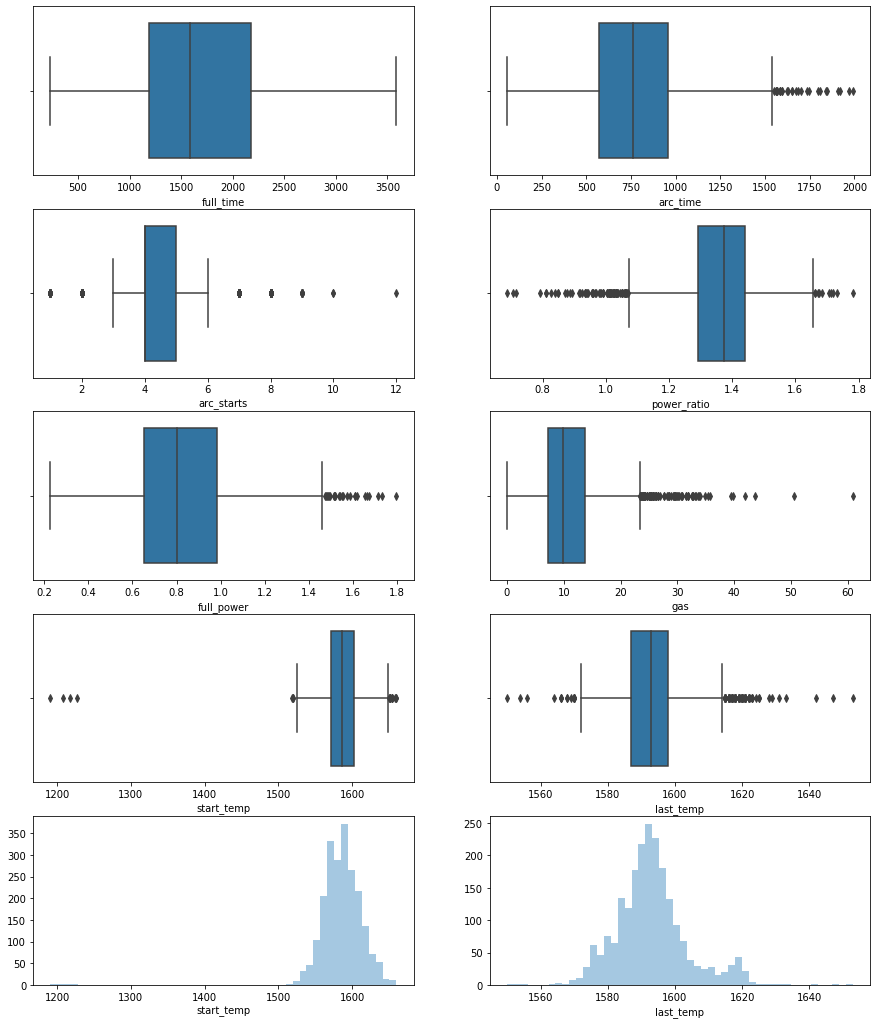

In [58]:
fig, axes = plt.subplots(5, 2)
fig.set_size_inches(15, 18)

sns.boxplot(data['full_time'], ax=axes[0,0])
sns.boxplot(data['arc_time'], ax=axes[0,1])
sns.boxplot(data['arc_starts'], ax=axes[1,0])
sns.boxplot(data['power_ratio'], ax=axes[1,1])
sns.boxplot(data['full_power'], ax=axes[2,0])
sns.boxplot(data['gas'], ax=axes[2,1])
sns.boxplot(data['start_temp'], ax=axes[3,0])
sns.boxplot(data['last_temp'], ax=axes[3,1])
sns.distplot(data['start_temp'], kde=False, ax=axes[4,0])
sns.distplot(data['last_temp'], kde=False, ax=axes[4,1])

plt.show()

**По диаграммам размаха можно выделить следующие особенности:**

1) Разница во времени в измерениях температур как правило не превышает 1 часа, но есть небольшое число измерений превышающих это значение. Возможно, их следует удалить.

2) Большая часть партий нагревалась за время не более получаса, но сущесвтуют партии, время нагрева на которых существенно больше. Отмести их не получится, т.к. это теоретически может быть обусловленно тех процессом и логично должно отражаться на итоговой температуре.

3) На графиках к с количеством нагревов электродами, соотношением мощностей, объема продувки газом и полной мощности также присутсвуют выбросы, но они могут быть обусловлены тех. процессом, поэтому внесение корректировок не потребуется.

4) Значения стартовой температуры меньше 1500 градусов не выглядят правдоподобными, особенно с учетом того, что и минимальная итоговая температура - около 1540 градусов. Предположим, что это ошибки измерения, и удалим их.

5) На гистограмме последней измеренной температуры хорошо заметен участок после 1640 градусов - он выглядит странно, вероятно - это перегрев или ошибки измерений. Возможно, его тоже стоит удалить.

In [24]:
len(data[data['full_time'] > 3600])

101

Больше часа в длительности времени между первым и последним замером температуры - 101 измерение, т.е. порядка 4% от всей выборки - удалим их.

In [25]:
keys_to_drop = data[data['full_time'] > 3600].index

Удалим строки со значениями стартовой температуры меньше 1500 градусов.

In [26]:
keys_to_drop = keys_to_drop.append(start_temp[start_temp < 1500].index)

Также удалим строки с последней измеренной температурой более 1640 градусов.

In [27]:
keys_to_drop = keys_to_drop.append(last_temp[last_temp > 1640].index)

In [28]:
len(keys_to_drop)

185

Всего удаляемых измерений - 185, что является 7% от общей выборки. Приемлемо для удаления.

In [29]:
data = data.drop(keys_to_drop)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2291 entries, 0 to 2472
Data columns (total 10 columns):
key            2291 non-null int64
full_time      2291 non-null float64
start_time     2291 non-null datetime64[ns]
arc_time       2291 non-null float64
arc_starts     2291 non-null float64
power_ratio    2291 non-null float64
full_power     2291 non-null float64
start_temp     2291 non-null float64
last_temp      2291 non-null float64
gas            2291 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 196.9 KB


Также дополним датасет с данными по сыпучим и проволочным материалам. Заметим, что пропуски в этих таблицах эквивалентны нулевым значениям, поэтому заполним их нулями.

In [30]:
data = data.merge(bulk, on='key')
data = data.merge(wire, on='key')

In [31]:
data = data.fillna(0)

## Обучение модели.

Подготовим отдельный датасет для обучения модели. Датасет *data* оставим для изучения влияния времени добавления сыпучих и проволочных материалов (точнее разницы во времени между началом нагрева и добавлением этих материалов)

In [32]:
df = data.drop(['key','start_time'], axis=1).reset_index(drop=True)

In [33]:
#df.to_csv('last_data.csv', index=False)

Подготовим тренировочный и тестовый датасеты, разделив выборку в соотношении 80/20%.

In [34]:
X = df.drop(['last_temp'], axis=1)
y = df['last_temp']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

Данные в датасетах необходимо отмасштабировать, для этого будем использовать StandardScaler. Также с помощью GridSearch преберем простые модели и выберем из них лучшую для дальнейшего подбора гиперпараметров.

In [36]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('model', LinearRegression())])
param_grid = [{'model': [LinearRegression()]}, 
               {'model': [Ridge()]}, 
               {'model': [Lasso()]}, 
               {'model': [SGDRegressor()]}, 
               {'model': [ElasticNet()]}, 
               {'model': [SVR(kernel='poly')]}, 
               {'model': [LinearSVR()]}, 
               {'model': [RandomForestRegressor()]}]

In [37]:
grid_model = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_model.fit(X_train, y_train);
grid_model.best_params_

{'model': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)}

Лучшие результаты показала модель случайного леса.
Вычислим MAE для этой модели.

In [38]:
mean_absolute_error(y_test, grid_model.predict(X_test))

5.700231481481479

Подбор гиперпараметров для модели для модели случайного леса не дает ощутимых результатов.

*подбор параметров осуществлялся с помощью GridSearch в Collab*

Проверим модель градиентного бустинга LightGBM. Для кросс-валидации будем использовать алгоритм KFold.

In [42]:
gbm = lgb.LGBMRegressor(random_state=12345)
kfold = KFold(n_splits=3)

In [44]:
param_grid = {'num_leaves'    : [23, 27, 31],
              'max_depth'         : [7, 8, 9],
              'learning_rate' : [0.008, 0.01, 0.015],
              'num_iterations'    : [700, 850, 1000]
                 }
grid = GridSearchCV(gbm, param_grid = param_grid, cv = kfold, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train, verbose=False)
grid.best_params_

{'learning_rate': 0.008,
 'max_depth': 8,
 'num_iterations': 1000,
 'num_leaves': 23}

In [45]:
mean_absolute_error(y_test, grid.predict(X_test))

5.51416456944225

МАЕ для модели градиентного бустинга - 5,5 градусов. Необходимая ключевая метрика достигнута.

Оценим степени влияния каждого из признаков на предсказания модели.

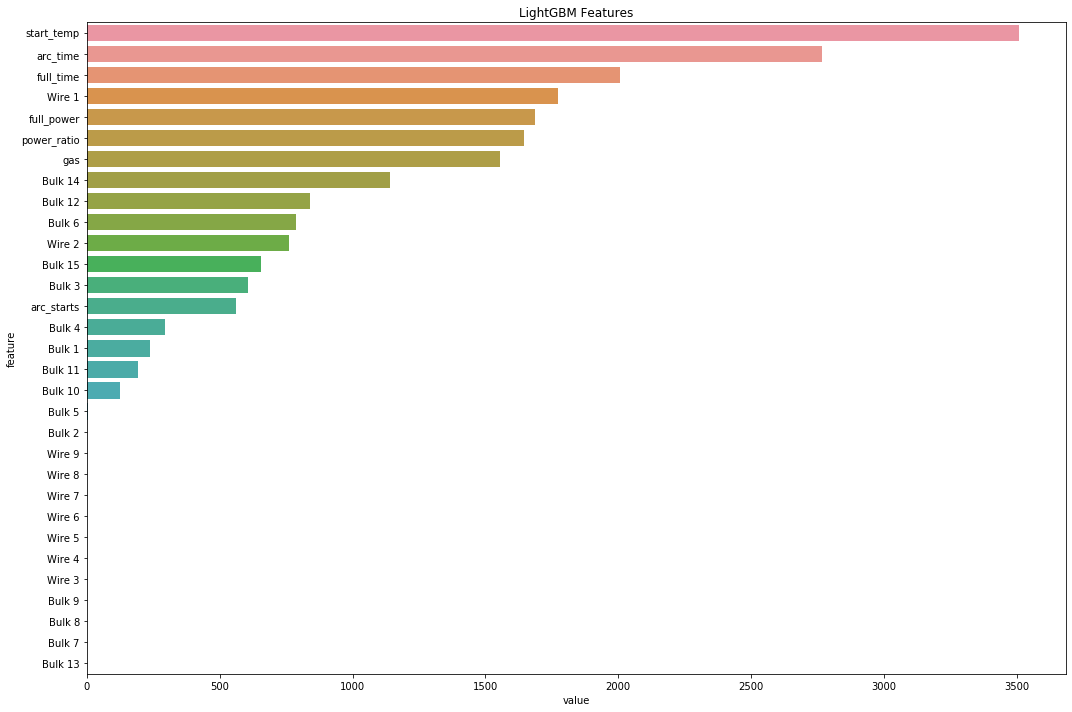

In [57]:
feature_imp = pd.DataFrame(sorted(zip(grid.best_estimator_.feature_importances_,X.columns)), columns=['value','feature'])

plt.figure(figsize=(15, 10))
sns.barplot(x="value", y="feature", data=feature_imp.sort_values(by="value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

Вполне логично, что главным влияющим признаком оказалась стартовая температура.

Можно заметить, что некоторые из признаков (сыпучие и проволочные материалы) незначительно влияют на модель или не влияют вовсе. Без потери качества их можно удалить при необходимости (ниже функция для этого).

In [55]:
def drop_features(df, feature_imp):
    features_to_drop = feature_imp[feature_imp['value'] == 0]['feature']
    df_2 = df.drop(features_to_drop, axis=1)
    return df_2

Для оценки работы моделей построим графики их предсказаний и сравним их с реальными данными.

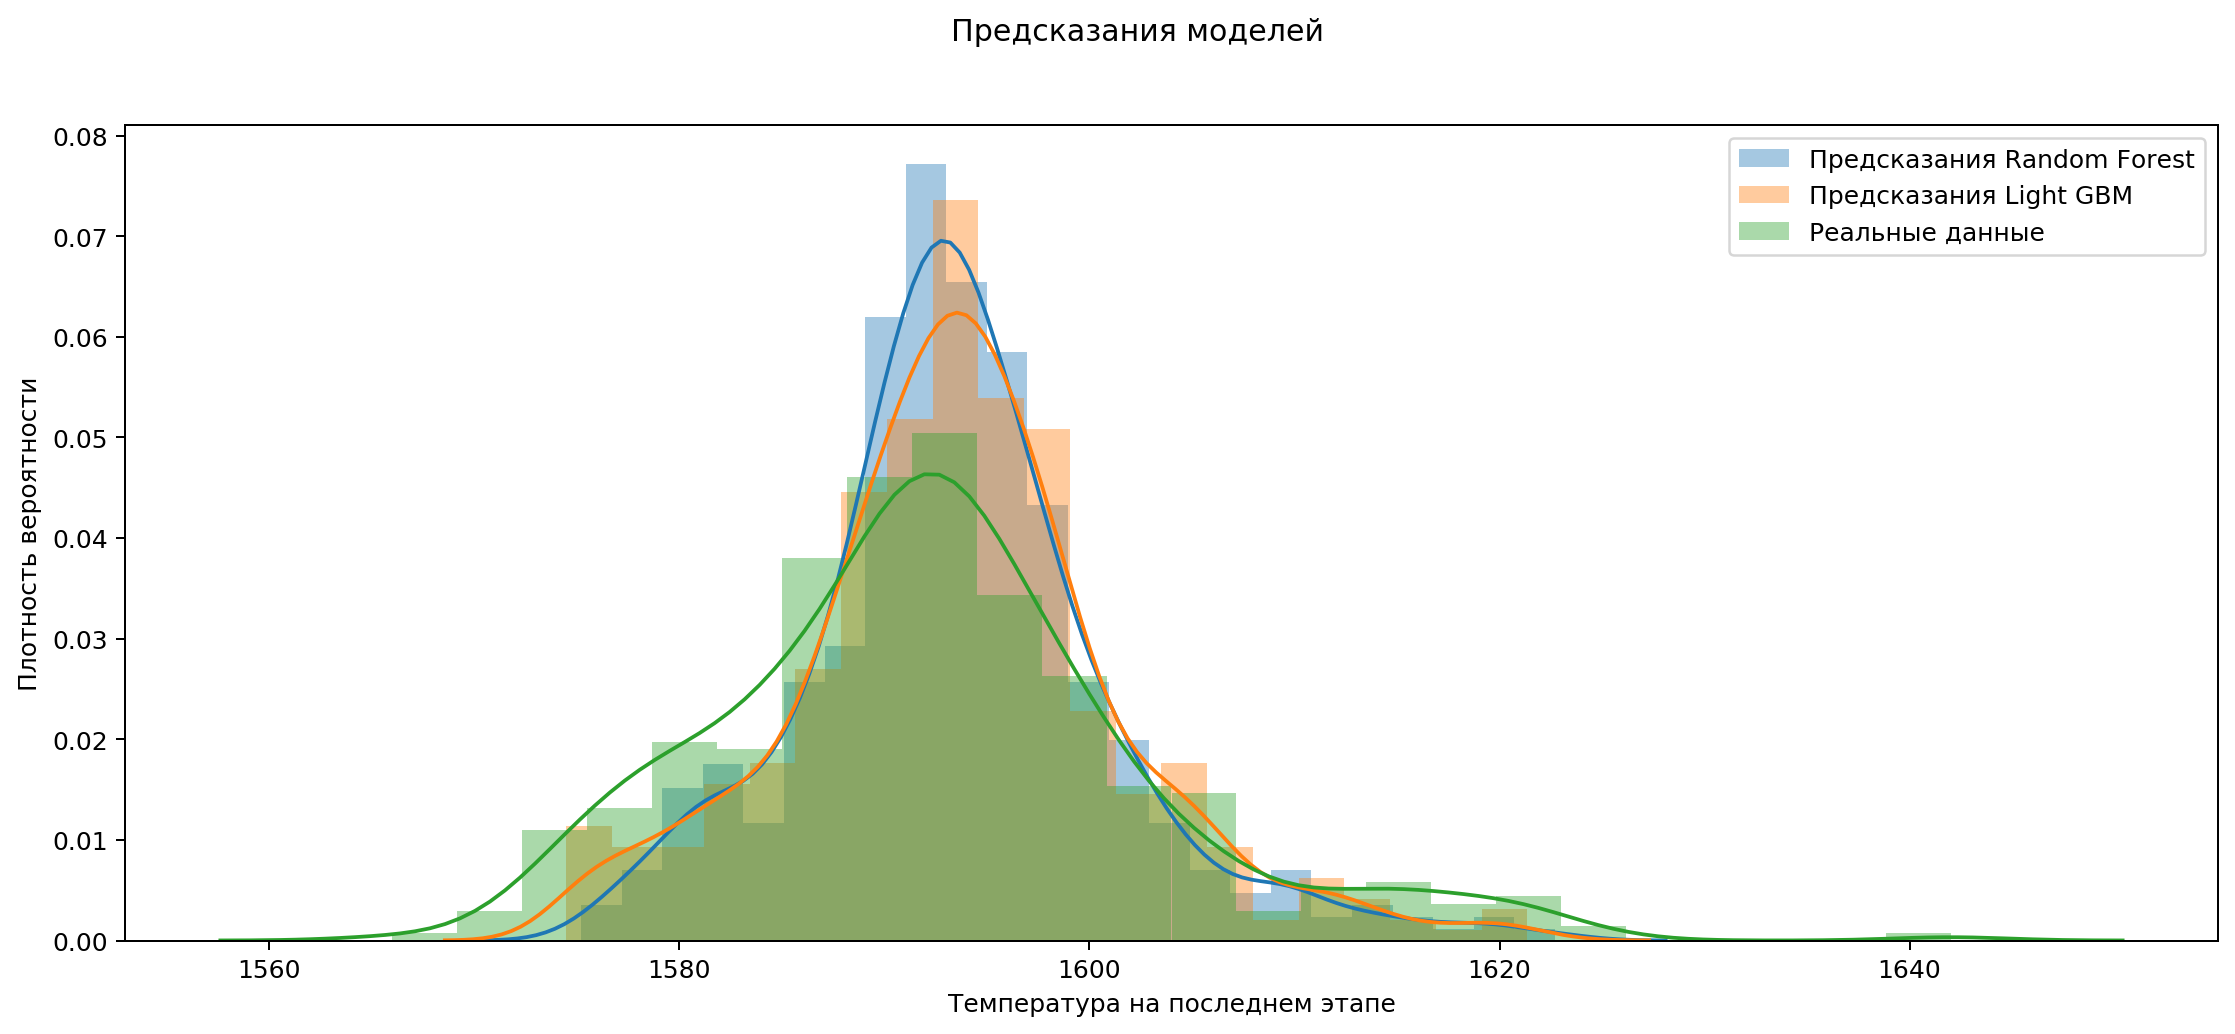

In [56]:
plt.figure(figsize=(15,6), dpi=180)

sns.distplot(grid_model.predict(X_test), label = 'Предсказания Random Forest')
sns.distplot(grid.predict(X_test), label = 'Предсказания Light GBM')
sns.distplot(y_test, label = 'Реальные данные')

plt.xlabel('Температура на последнем этапе')
plt.ylabel('Плотность вероятности')

plt.suptitle('Предсказания моделей')

plt.legend()

plt.show()

По графикам видно, что обе модели излишне нормализуют ключевой признак. При этом хорошо заметно, что градиетный бустинг справился с задачей заметно лучше, особенно для значений далеких от среднего.

# Вывод.

В рамках данной работы были предобработаны основные данные, сгруппированны по номеру партии и выделены ключевые признаки.

Часть данных пришлось исключить из обучения модели - некорретные значения температур, неудачные партии (ни одного или одно измерение).

Для итогового датасета были подобраны основные модели - модель случанойного леса и градиентного бустинга, показавшие значение ключевой метрики МАЕ 5,7 и 5,5 соответсвенно.

Изучена степень влияния каждого признака на лучшую модель.

Проведена оценка предсказаний моделей.

Итог: МАЕ = 5,5 градусов говорит о том, что модель с достаточной точностью прогнозирует конечную температуру стали, что, безусловно, поможет оптимизировать потребление энергии на этапе обработки металла.

*P.S. изучение остальных признаков возможно в следующей итерации.